In [1]:
%%capture
import sys
!pip install tensorflow-addons
!git clone https://github.com/ICascha/QuantGANs-replication.git
sys.path.append('/content/QuantGANs-replication/')

In [2]:
from backend.preprocessing import *
from backend.metrics import *
from backend.gan import CGAN
from backend.tcn import make_TCN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.random import normal
from tensorflow.keras.utils import Progbar
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Input
import tensorflow as tf
from datetime import datetime, timedelta

from google.colab import files

In [3]:
# dataset with returns and covar info of most publicly traded US stocks, can be gathered from: 
# https://www.openicpsr.org/openicpsr/project/112877/version/V1/view
df = pd.read_csv('/content/covar_dataset.csv', parse_dates=['week']).iloc[: ,1:]
sic = df['HSICCD'].astype('str').str
df = df[sic.startswith('60') | sic.startswith('61') | sic.startswith('62') | sic.startswith('6711') | sic.startswith('6712')]
df = df[['week', 'ret', 'marketret', 'permno', 'SIZE']]
# train cutt-off
df = df[df['week'] <= np.datetime64('2005-01-01')]

In [4]:
# standardize returns
for permno in df['permno'].unique():
    mask = df['permno'] == permno
    df.loc[mask, 'ret'] = (df[mask]['ret'] - df[mask]['ret'].mean())/df[mask]['ret'].std()

In [5]:
# standardize marketret
df_mkt = df[['week', 'marketret']].drop_duplicates()
# market returns are not given as losses originally
std_mkt =  (df_mkt['marketret'] - df_mkt['marketret'].mean())/df_mkt['marketret'].std() * -1
mapping_mkt = {x:y for x,y in zip(df_mkt['marketret'], std_mkt)}
df = df.replace({'marketret': mapping_mkt})

In [6]:
dilations = 2**np.arange(3)
fixed_filters, moving_filters = 50, 10
rfs = 1 + 2 * sum(dilations)

discriminator = make_TCN(dilations, fixed_filters, moving_filters, False, True, False, [4, rfs*2-1, 1], block_size=4)
generator = make_TCN(dilations, fixed_filters, moving_filters, False, False, False, [8, None, 3], halve_output_series=True)

In [7]:
df = df.sort_values(by='week')

length = 2*rfs - 1
n_series = 3

a_week = np.timedelta64(1, 'W')
window_length =  np.timedelta64(length-1, 'W')
window_permno = []
valid_windows = []

unique_weeks = df['week'].unique()

pb = Progbar(len(unique_weeks))

# check for each window started from all unique weeks in dataset which companies
# do not have any missing values in this dataset, then save those companies
# pemrno and size in window_permno, and if > n_series companies are in a window
# it can be used for training is is thus valid.
for j, week in enumerate(unique_weeks):

    window_permno.append([])
    week_range = (week, week + window_length)
    df_window = df[(df['week'] >= week_range[0]) & (df['week'] <= week_range[1])]
    
    for permno in df_window['permno'].unique():
        permno_mask = df_window['permno'] == permno

        if sum(permno_mask) == length:
                window_permno[-1].append((permno, df_window[permno_mask]['SIZE'].mean()))
    
    window_permno[-1] = np.array(window_permno[-1])
    if len(window_permno[-1]) >= n_series:
        valid_windows.append(j)
    pb.update(j)

587/589 [============================>.] - ETA: 0s

In [8]:
min_week = df['week'].min().to_numpy()

from tensorflow.keras.layers import Input

class cGANMultiAsset(CGAN):
    
    #Override train method
    def train(self, window_permno, valid_windows, length, batch_size, n_batches, additional_d_steps):
        progress = Progbar(n_batches)

        for n_batch in range(n_batches):
            
            batch = np.zeros((batch_size, length, n_series + 1))
            windows_batch = np.random.choice(valid_windows, size=batch_size, replace = len(valid_windows) < batch_size)
            for j, w in enumerate(windows_batch):
                
                delta_week = np.timedelta64(w, 'W')
                week_range = unique_weeks[w], unique_weeks[w+length-1]
                df_window = df[(df['week'] >= week_range[0]) & (df['week'] <= week_range[1])]
                # sample multinomially with p = lambda * company size
                assets = np.random.choice(window_permno[w][:, 0], replace=False, p=window_permno[w][:, 1]/window_permno[w][:, 1].sum(), size=n_series)
                for i in range(len(assets)-1):
                    if len(df_window[df_window['permno'] == assets[i]]['ret'].to_numpy()) != 29:
                        print(df_window[df_window['permno'] == assets[i]])

                    batch[j,:,i] = df_window[df_window['permno'] == assets[i]]['ret'].to_numpy()
            
            batch[j, :, n_series-1:] = df_window[df_window['permno'] == assets[-1]][['ret', 'marketret']].to_numpy()

            batch = np.swapaxes(np.expand_dims(batch, -1), 1, 2).astype('float32')
            self.train_step(batch, batch_size, additional_d_steps)

            self.train_hook(n_batch)

            progress.update(n_batch + 1)
        
gan = cGANMultiAsset(discriminator, generator, rfs*2-1, lr_d=1e-4, lr_g=9e-5)

In [9]:
batch_size = 64
n_steps = 5000
gan.train(window_permno, valid_windows, rfs*2-1, batch_size, n_steps, 0)

5000/5000 [==============================] - 2958s 579ms/step


In [10]:
%%capture
generator.save('cond_generator')

INFO:tensorflow:Assets written to: cond_generator/assets


In [11]:
!zip -r train_covar_banks_cond_generator.zip cond_generator/ 

  adding: cond_generator/ (stored 0%)
  adding: cond_generator/variables/ (stored 0%)
  adding: cond_generator/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: cond_generator/variables/variables.index (deflated 78%)
  adding: cond_generator/keras_metadata.pb (deflated 96%)
  adding: cond_generator/saved_model.pb (deflated 94%)
  adding: cond_generator/assets/ (stored 0%)


In [12]:
files.download('train_covar_banks_cond_generator.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# sic's cross referenced with WRDS database on permno
df = pd.read_csv('/content/covar_dataset.csv', parse_dates=['week']).iloc[: ,1:]
sic = df['HSICCD'].astype('str').str
df = df[sic.startswith('60') | sic.startswith('61') | sic.startswith('62') | sic.startswith('6711') | sic.startswith('6712')]
df = df[['week', 'ret', 'marketret', 'permno', 'SIZE', 'DCoVaR_CS_p95']]

In [14]:
# standardize returns
for permno in df['permno'].unique():
    mask = df['permno'] == permno
    df.loc[mask, 'ret'] = (df[mask]['ret'] - df[mask]['ret'].mean())/df[mask]['ret'].std()

In [15]:
# standardize marketret
df_mkt = df[['week', 'marketret']].drop_duplicates()
# market returns are not given as losses originally
std_mkt =  (df_mkt['marketret'] - df_mkt['marketret'].mean())/df_mkt['marketret'].std() * -1
mapping_mkt = {x:y for x,y in zip(df_mkt['marketret'], std_mkt)}
df = df.replace({'marketret': mapping_mkt})
df = df.sort_values(by='week')

In [16]:
# train cutt-off after standardization, note fitting a standardizer
# on the test set introduces a slight bias but there is so much data
# before 2005 that this effect ought to be limited
df = df[df['week'] >= np.datetime64('2005-01-01')]

In [17]:
%%capture
test_leh = df[df['permno'] == 80599]
test_gs = df[df['permno'] == 86868]
test_boa = df[df['permno'] == 59408]

test_leh['DCoVaR_leh'] = test_leh.loc[:, 'DCoVaR_CS_p95']
test_gs['DCoVaR_gs'] = test_gs.loc[:, 'DCoVaR_CS_p95']
test_boa['DCoVaR_boa'] = test_boa.loc[:, 'DCoVaR_CS_p95']


test_leh['ret_leh'] = test_leh.loc[:, 'ret']
test_gs['ret_gs'] = test_gs.loc[:, 'ret']
test_boa['ret_boa'] = test_boa.loc[:, 'ret']

test_df = test_leh[['week', 'ret_leh', 'DCoVaR_leh', 'marketret']]
test_df = test_df.merge(test_gs[['week', 'ret_gs', 'DCoVaR_gs']], left_on='week', right_on='week')
test_df = test_df.merge(test_boa[['week', 'ret_boa', 'DCoVaR_boa']], left_on='week', right_on='week')

In [18]:
test_mat = test_df[['ret_leh', 'ret_gs', 'ret_boa', 'marketret']].to_numpy()
window_length = 14
sim_size = 512
pred_covar = np.zeros((len(test_mat) - window_length - 5, 4))
asset = 0 # condition on lehman VaR
q = .95

for i in range(2, len(test_mat) - window_length - 3):
    test_mat[i:14+i]

    total_z = []

    for offset in [-2, -1, 0, 1, 2, 3]:

        data = np.expand_dims(test_mat[i+offset:14+i+offset].T, -1).astype('float32')

        noise = tf.concat([tf.zeros([sim_size, data.shape[0], window_length, 3]), tf.random.normal([sim_size, data.shape[0], window_length + 1, 3])], axis=2)
        real_part = tf.repeat(tf.concat([tf.convert_to_tensor(np.repeat(np.expand_dims(data, 0), sim_size, 0)), 
                                         tf.zeros([sim_size, data.shape[0], window_length + 1, 1])], axis=2), 3, axis=3)
        noise_input = tf.concat([real_part, noise], axis=1)

        z = generator(noise_input, training=False).numpy().squeeze()
        z = np.moveaxis(z, 0, 1)
        total_z.append(z)

    z = np.concatenate(total_z, axis=1)

    VaR_mask_50 = z[asset] >= np.quantile(z[asset], .5)
    VaR_mask_q = z[asset] >= np.quantile(z[asset], q)

    delta_covar = np.quantile(z[:, VaR_mask_q], q, axis=1) - np.quantile(z[:, VaR_mask_50], q, axis=1)
        
    pred_covar[i-2] = delta_covar

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

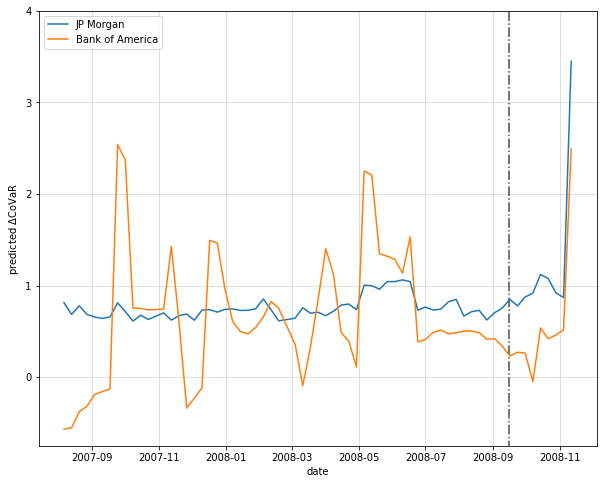

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(test_df['week'][-len(pred_covar[:, 1:]):] + np.timedelta64(8, 'W'), pred_covar[:, 1:-1])
ax.legend(['JP Morgan', 'Bank of America'], loc='upper left')
ax.set_xlabel('date')
ax.set_ylabel('predicted $\Delta$CoVaR');
ax.vlines(np.datetime64('2008-09-15'), -10, 10, linestyles='dashdot', alpha=0.7)
ax.set_ylim(-0.75, 4)
ax.grid(alpha=0.5)
plt.savefig('pred_dcovar_banks.png')
files.download('pred_dcovar_banks.png')